In [1]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Food.com   Dataset
- https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
- https://aclanthology.org/D19-1613/

In [2]:
interactions_df = pd.read_csv('interactions_train.csv')

interactions_df.head(5)

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [3]:
recipes_df = pd.read_csv('PP_recipes.csv')

recipes_df.head(5)

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


In [4]:
user_df = pd.read_csv('PP_users.csv')

user_df.head(5)

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


In [5]:
raw_interactions_df = pd.read_csv('RAW_interactions.csv')
raw_interactions_df['review']= raw_interactions_df['review'].astype(str)
raw_interactions_df.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [6]:
raw_recipes_df = pd.read_csv('RAW_recipes.csv')

raw_recipes_df.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [7]:
raw_interactions_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132367 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


## Sentimant analysis on the data
- It will take lot of time , so saving the results

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
sw_nltk = stopwords.words('english')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cseka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cseka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cseka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
from textblob import TextBlob

In [10]:

def sentiment_analysis(raw_interactions_df):
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(text):
   return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 raw_interactions_df['TextBlob_Subjectivity'] =    raw_interactions_df['review'].apply(getSubjectivity)
 raw_interactions_df ['TextBlob_Polarity'] =  raw_interactions_df['review'].apply(getPolarity)
 def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
 raw_interactions_df ['Analysis'] = raw_interactions_df ['TextBlob_Polarity'].apply(getAnalysis )
 return raw_interactions_df

In [11]:
#sentiment_analysis(raw_interactions_df)

### Save the result 

In [12]:
#raw_interactions_df.to_csv('raw_interactions_sentiment_analysis.csv')

In [13]:
raw_interactions_df=pd.read_csv('raw_interactions_sentiment_analysis.csv')

In [14]:
raw_interactions_df

,Unnamed: 0,user_id,recipe_id,date,rating,review,TextBlob_Subjectivity,TextBlob_Polarity,Analysis
0,0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,0.370000,0.270000,Positive
1,1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",0.665306,0.242857,Positive
2,2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,0.456667,0.366667,Positive
3,3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,0.400000,0.350000,Positive
4,4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",0.433333,-0.208333,Negative
...,...,...,...,...,...,...,...,...,...
1132362,1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,0.500000,0.300000,Positive
1132363,1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,0.653228,0.339904,Positive
1132364,1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,0.579720,0.463068,Positive
1132365,1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,0.614231,0.575000,Positive


C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Subjectivity ')

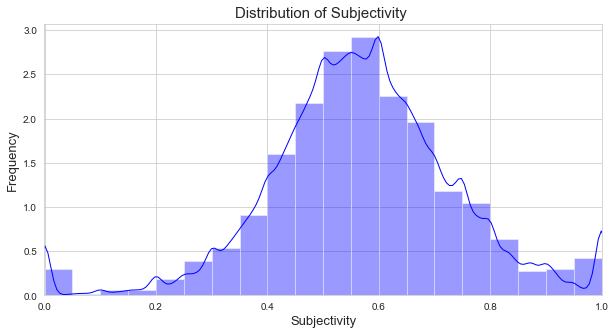

In [15]:
# Density Plot and Histogram of subjectivity
plt.figure(figsize=(10,5))
sns.distplot(raw_interactions_df['TextBlob_Subjectivity'], hist=True, kde=True,
bins=int(20), color = 'blue',
kde_kws={'linewidth': 1})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity ', fontsize=15)

C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Polarity ')

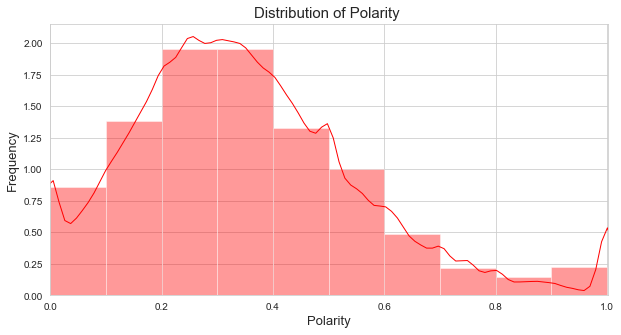

In [16]:
# Density Plot and Histogram of subjectivity
plt.figure(figsize=(10,5))
sns.distplot(raw_interactions_df['TextBlob_Polarity'], hist=True, kde=True,
bins=int(20), color = 'red',
kde_kws={'linewidth': 1})
plt.xlim([-0.001,1.001]),
plt.xlabel('Polarity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Polarity ', fontsize=15)

<AxesSubplot:>

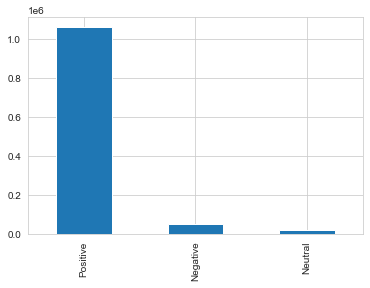

In [17]:
raw_interactions_df['Analysis'].value_counts().plot(kind='bar')

In [18]:
raw_interactions_df[(raw_interactions_df['Analysis']=='Negative') & (raw_interactions_df['rating']<=3)]

,Unnamed: 0,user_id,recipe_id,date,rating,review,TextBlob_Subjectivity,TextBlob_Polarity,Analysis
63,63,1874846,79222,2011-04-04,0,FABULOUS!<br/><br/>I could not afford any of t...,0.433333,-0.104167,Negative
130,130,1108690,36144,2009-01-02,1,What a disastrous recipe. We used fat free yo...,0.598910,-0.012917,Negative
194,194,2001719206,195977,2017-09-18,1,This was really terrible. It was overwhelmingl...,0.883333,-0.383333,Negative
321,321,149342,92154,2004-07-05,3,Cook time on the broiling is a little long-- t...,0.395238,-0.025595,Negative
396,396,245429,183729,2006-12-31,1,"Sorry, but we just didn't think too much of th...",0.600000,-0.150000,Negative
...,...,...,...,...,...,...,...,...,...
1132209,1132209,2002212283,536013,2018-07-08,1,Dino Nuggets are disgusting so called meat nug...,0.600000,-0.450000,Negative
1132210,1132210,2000497761,536013,2018-07-09,0,Kyle D...what may I ask what was the disgustin...,0.830000,-0.280000,Negative
1132244,1132244,2001078714,125417,2016-07-09,0,hi i thought I try this recipe for a change . ...,0.616667,-0.138889,Negative
1132292,1132292,1986433,103587,2011-08-19,1,"Sorry, but this is awful the mix of ingredient...",1.000000,-0.166667,Negative


### Lets drop rows that has bot less rating and negetive sentiment

In [19]:
raw_interactions_df[(raw_interactions_df['Analysis']=='Negative') & (raw_interactions_df['rating']>=4)]

,Unnamed: 0,user_id,recipe_id,date,rating,review,TextBlob_Subjectivity,TextBlob_Polarity,Analysis
4,4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",0.433333,-0.208333,Negative
52,52,1447190,79222,2010-03-18,5,"really good,I did make adjustments to my needs...",0.383333,-0.133333,Negative
61,61,152118,79222,2011-01-02,5,I enjoyed this recipe. The only change I made...,0.596667,-0.086667,Negative
81,81,52476,181765,2006-08-15,5,We have been eating this bbq sauce for years! ...,0.615000,-0.166364,Negative
82,82,37722,181765,2007-03-12,5,This is excellent and the same recipe I've alw...,0.451095,-0.004238,Negative
...,...,...,...,...,...,...,...,...,...
1132164,1132164,6357,102340,2004-10-21,5,This is one of my favourite side dishes. I use...,0.357143,-0.214286,Negative
1132202,1132202,56003,392411,2009-11-15,5,This was extremely tasty! I did deviate from ...,0.648148,-0.260301,Negative
1132335,1132335,1359325,117403,2010-05-22,5,Made this with thighs. Great way to start gett...,0.672222,-0.009722,Negative
1132350,1132350,417131,241491,2007-09-05,4,I made this over the weekend and changed it up...,0.425000,-0.184375,Negative


### Look at distribution of ratings

<AxesSubplot:xlabel='rating'>

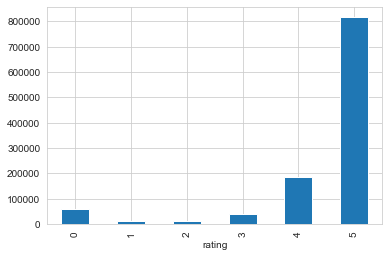

In [20]:
raw_interactions_df.groupby(['rating']).size().plot(kind = "bar")

### Data based on sentiments

<AxesSubplot:xlabel='Analysis'>

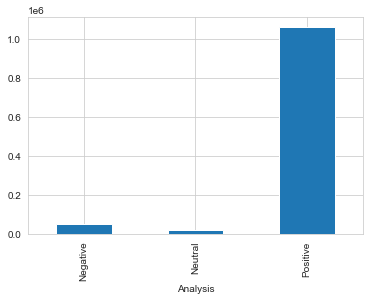

In [21]:
raw_interactions_df.groupby(['Analysis']).count()['rating'].plot(kind = "bar")

In [22]:
pos=raw_interactions_df[raw_interactions_df['Analysis']=='Positive']['recipe_id'].value_counts().reset_index(name='Positive')

In [23]:
neg=raw_interactions_df[raw_interactions_df['Analysis']=='Negative']['recipe_id'].value_counts().reset_index(name='Negetive')

In [24]:
neu=raw_interactions_df[raw_interactions_df['Analysis']=='Neutral']['recipe_id'].value_counts().reset_index(name='Neutral')

In [25]:
mean=raw_interactions_df.groupby( ['recipe_id']).mean()


In [26]:
unique_ids=pd.DataFrame({'recipe_id':raw_interactions_df.recipe_id.unique()})
unique_ids=unique_ids.merge(neu, left_on='recipe_id', right_on='index', how='left').fillna(0)
unique_ids=unique_ids.merge(neg, left_on='recipe_id', right_on='index', how='left').fillna(0)
unique_ids=unique_ids.merge(pos, left_on='recipe_id', right_on='index', how='left').fillna(0)
unique_ids=unique_ids.merge(mean, left_on='recipe_id', right_on='recipe_id', how='left').fillna(0)
unique_ids=unique_ids[['recipe_id','Neutral','Positive','Negetive','rating']]
unique_ids.head(1)

,recipe_id,Neutral,Positive,Negetive,rating
0,40893,0.0,2.0,0.0,4.5


In [27]:
df=raw_interactions_df .merge(unique_ids, left_on='recipe_id', right_on='recipe_id', how='inner').fillna(0)
raw_interactions_df=df[['user_id','recipe_id','date','Analysis','Positive','Negetive','Neutral','rating_y']]

In [28]:
raw_interactions_df=raw_interactions_df.rename(columns = {'rating_y':'rating'})


#### Correlation of ratings with Sentiments

In [29]:
popular_df=raw_interactions_df
popular_df=popular_df.drop_duplicates(subset=['recipe_id'])

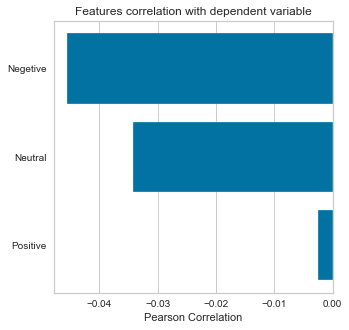

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [30]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['Positive', 'Neutral', 'Negetive']

X, y = raw_interactions_df[feature_names], raw_interactions_df['rating']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(5,5)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

### Popularity Based Recommendation 

In [31]:
popular_df.groupby('recipe_id')['recipe_id'].size()

recipe_id
38        1
39        1
40        1
41        1
43        1
         ..
537459    1
537485    1
537543    1
537671    1
537716    1
Name: recipe_id, Length: 231637, dtype: int64

In [32]:
top_result=popular_df.sort_values(by=['Positive','rating'], ascending=[False,False]).head(10)

In [33]:
top_result=top_result.merge(raw_recipes_df, left_on='recipe_id', right_on='id', how='left').fillna(0)

In [34]:
top_result[['name','recipe_id','Positive','Negetive','Neutral','rating','tags','n_steps','ingredients']]

,name,recipe_id,Positive,Negetive,Neutral,rating,tags,n_steps,ingredients
0,best banana bread,2886,1504.0,54.0,55.0,4.185989,"['time-to-make', 'course', 'main-ingredient', ...",13,"['butter', 'granulated sugar', 'eggs', 'banana..."
1,to die for crock pot roast,27208,1498.0,67.0,36.0,4.288570,"['weeknight', 'time-to-make', 'course', 'main-...",7,"['beef roast', 'brown gravy mix', 'dried itali..."
2,crock pot chicken with black beans cream cheese,89204,1417.0,144.0,18.0,4.220393,"['time-to-make', 'course', 'main-ingredient', ...",5,"['boneless chicken breasts', 'black beans', 'c..."
3,creamy cajun chicken pasta,39087,1359.0,61.0,28.0,4.541436,"['30-minutes-or-less', 'time-to-make', 'course...",4,"['boneless skinless chicken breast halves', 'l..."
4,best ever banana cake with cream cheese frosting,67256,1257.0,38.0,27.0,4.329047,"['weeknight', 'time-to-make', 'course', 'main-...",18,"['bananas', 'lemon juice', 'flour', 'baking so..."
5,yes virginia there is a great meatloaf,54257,1215.0,54.0,36.0,4.213793,"['time-to-make', 'course', 'main-ingredient', ...",15,"['ground beef', 'bread', 'egg', 'vidalia onion..."
6,jo mama s world famous spaghetti,22782,1177.0,31.0,26.0,4.423015,"['weeknight', 'time-to-make', 'course', 'main-...",10,"['italian sausage', 'onion', 'garlic cloves', ..."
7,whatever floats your boat brownies,32204,1150.0,43.0,27.0,4.525410,"['60-minutes-or-less', 'time-to-make', 'course...",14,"['butter', 'unsweetened cocoa', 'sugar', 'eggs..."
8,kittencal s italian melt in your mouth meatballs,69173,953.0,18.0,26.0,4.708124,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['ground beef', 'egg', 'parmesan cheese', 'bre..."
9,creamy burrito casserole,33919,823.0,39.0,15.0,4.374002,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['ground beef', 'yellow onion', 'taco seasonin..."


## Prepare train and test dataset

In [35]:
rating_df=raw_interactions_df

In [36]:
x = rating_df.groupby('recipe_id').count()['rating'] >=60
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['recipe_id'].isin(userIndex)]
y = nm_rating_df.groupby('user_id').count()['rating']>=100
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['user_id'].isin(items)]
rating_df.shape

(14357, 8)

In [37]:
train_df=rating_df
train_df=train_df.sort_values(by=['user_id','date'], ascending=[False,False]) 
train_df.shape
test_df=train_df.groupby('user_id').head(30)
test_df.shape
data=train_df[~train_df.isin(test_df).all(1)]


### Contant Based Filtering

- This data frame contain large number of records.So we will apply multiple filtering before applying similarity methods.
- First we filter out records that got more negetive feedback.No point to recommend such items to users
- Also we will consider items that got high feedback from user

### Columns that are insightful:
- Description
- Ingradiants
- tags
- nutrition

In [38]:
all_Data=data[['recipe_id','Positive','Negetive','Neutral','rating']]
all_Data=all_Data.drop_duplicates()
all_Data.head(2)

,recipe_id,Positive,Negetive,Neutral,rating
686747,38298,578.0,36.0,30.0,4.340062
64937,97496,654.0,33.0,14.0,4.298146


In [39]:
contant_df=all_Data.merge(raw_recipes_df , left_on='recipe_id', right_on='id', how='left').fillna(0)

In [40]:
contant_df=contant_df[ (((contant_df['Positive']>contant_df['Negetive'])\
              | (contant_df['Neutral']>contant_df['Negetive'])) & (contant_df['rating'] >=2))]

In [41]:
contant_df=contant_df[ (contant_df['Positive']+contant_df['Negetive']+ (contant_df['Neutral'])>=20)]

In [42]:
contant_df.shape

(1583, 17)

### Lets see how we get the recommendations

In [43]:

contant_df['NewTag']= contant_df['ingredients'].str.replace(' ', '', regex=True)  +contant_df['description'].str.replace(' ', '_', regex=True) 
# contant_df['NewTag']= contant_df['ingredients'].str.replace(' ', '', regex=True) +contant_df['tags'].str.replace(' ', '_', regex=True) +contant_df['description'].str.replace(' ', '_', regex=True) 

In [44]:
contant_df=contant_df.reset_index()

In [45]:
contant_df=contant_df.drop_duplicates(subset=['recipe_id'])
contant_df.shape

(1583, 19)

### Now perform word embedding 
- This will take some time

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(contant_df['NewTag'].values.astype('str') ).toarray()

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity = cosine_similarity(vector)

In [48]:
contant_df[contant_df['name']=='the most ultimate buttery cream cheese pound cake'].index [0]

1581

In [49]:
def RecommendFood(food,contant_df,similarity):
    index  = contant_df[contant_df['name'] == food].index [0]
    #print(index)
    distance = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    result=[]
    for i in distance[1:11]:
      
        result.append(list(contant_df.iloc[i[0]])[0])
    return result    

In [50]:
resuls=RecommendFood('the most ultimate buttery cream cheese pound cake',contant_df,cosine_similarity)

In [51]:
result_df=contant_df[contant_df["index"].isin(resuls)].sort_values(by=['Positive','rating'], ascending=[False,False])

In [52]:
contant_df[contant_df["name"]=='the most ultimate buttery cream cheese pound cake']

,index,recipe_id,Positive,Negetive,Neutral,rating,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,NewTag
1581,1581,78552,58.0,5.0,2.0,4.369231,the most ultimate buttery cream cheese pound cake,78552,70,89831,2003-12-11,"['time-to-make', 'course', 'preparation', 'for...","[459.5, 37.0, 152.0, 21.0, 11.0, 71.0, 18.0]",13,"['preheat oven to 350 degrees f', 'generously ...",this is the most ultimate rich dense buttery p...,"['butter', 'cream cheese', 'sugar', 'eggs', 'v...",7,"['butter','creamcheese','sugar','eggs','vanill..."


In [53]:
result_df

,index,recipe_id,Positive,Negetive,Neutral,rating,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,NewTag
11,11,2886,1504.0,54.0,55.0,4.185989,best banana bread,2886,65,1762,1999-09-26,"['time-to-make', 'course', 'main-ingredient', ...","[272.8, 16.0, 97.0, 14.0, 7.0, 31.0, 14.0]",13,"['remove odd pots and pans from oven', 'prehea...",you'll never need another banana bread recipe ...,"['butter', 'granulated sugar', 'eggs', 'banana...",8,"['butter','granulatedsugar','eggs','bananas','..."
169,169,261889,404.0,16.0,7.0,4.379391,kittencal s buttery cut out sugar cookies w i...,261889,124,89831,2007-10-28,"['time-to-make', 'course', 'main-ingredient', ...","[144.2, 8.0, 50.0, 4.0, 3.0, 17.0, 7.0]",20,"['for cookies', 'in a large bowl combine butte...",you will not find a better sugar cookie anywhe...,"['butter', 'sugar', 'eggs', 'vanilla', 'almond...",13,"['butter','sugar','eggs','vanilla','almondextr..."
869,869,110683,175.0,6.0,4.0,4.654054,basic batter waffles,110683,20,160974,2005-02-08,"['30-minutes-or-less', 'time-to-make', 'course...","[345.3, 25.0, 17.0, 18.0, 17.0, 18.0, 13.0]",7,['mix all dry ingredients together using a lar...,this hearty waffle recipe comes from an issue ...,"['eggs', 'milk', 'vegetable oil', 'all-purpose...",9,"['eggs','milk','vegetableoil','all-purposeflou..."
750,750,125633,161.0,2.0,4.0,4.616766,cream cheese cinnamon crescents,125633,40,56251,2005-06-11,"['60-minutes-or-less', 'time-to-make', 'course...","[285.4, 23.0, 85.0, 10.0, 7.0, 42.0, 11.0]",11,['roll out one can of crescent rolls in bottom...,these are so yummy. would be perfect for brea...,"['crescent roll dough', 'cream cheese', 'sugar...",6,"['crescentrolldough','creamcheese','sugar','va..."
826,826,91644,123.0,3.0,2.0,4.414062,amanda s cheese pound cake,91644,105,55882,2004-05-22,"['time-to-make', 'course', 'cuisine', 'prepara...","[612.2, 49.0, 202.0, 12.0, 15.0, 95.0, 24.0]",7,"['preheat oven to 300f', 'cream butter , cream...",my daughter amanda found this recipe in a old ...,"['butter', 'cream cheese', 'sugar', 'eggs', 'f...",6,"['butter','creamcheese','sugar','eggs','flour'..."
655,655,76294,85.0,7.0,0.0,4.510870,vanilla sugar cookies,76294,25,35526,2003-11-12,"['30-minutes-or-less', 'time-to-make', 'course...","[105.5, 6.0, 33.0, 1.0, 2.0, 12.0, 5.0]",8,"['sift together flour , baking powder , and sa...",this is an adopted recipe that i am honored to...,"['all-purpose flour', 'baking powder', 'salt',...",7,"['all-purposeflour','bakingpowder','salt','uns..."
767,767,51199,83.0,4.0,6.0,3.827957,krispy kreme doughnuts copycat,51199,150,65056,2003-01-14,"['weeknight', 'time-to-make', 'course', 'main-...","[316.1, 18.0, 105.0, 6.0, 8.0, 28.0, 15.0]",27,['dissolve yeast in warm water in 2 1 / 2-quar...,"needs 1/2 cup shortening, not 1/3","['yeast', 'water', 'milk', 'sugar', 'salt', 'e...",14,"['yeast','water','milk','sugar','salt','eggs',..."
623,623,118140,82.0,6.0,0.0,4.352273,the ultimate chocolate brownie muffins,118140,40,89831,2005-04-20,"['60-minutes-or-less', 'time-to-make', 'course...","[260.4, 20.0, 84.0, 8.0, 7.0, 40.0, 11.0]",18,"['set oven to 350f', 'line 12 muffin tins with...",this recipe goes back to when my son was small...,"['baking cocoa', 'baking powder', 'butter', 'b...",11,"['bakingcocoa','bakingpowder','butter','boilin..."
868,868,129984,80.0,2.0,0.0,4.317073,grandma s buttermilk waffles,129984,35,37779,2005-07-15,"['60-minutes-or-less', 'time-to-make', 'course...","[414.6, 23.0, 24.0, 40.0, 27.0, 44.0, 18.0]",6,"['in a mixing bowl , add flour , baking powder...","well, someone's grandma, but not mine. from go...","['all-purpose flour', 'baking powder', 'salt',...",7,"['all-purposeflour','bakingpowder','salt','bak..."
551,551,16110,62.0,0.0,1.0,4.634921,toll house butterscotch chip cookies,16110,35,17608,2001-12-21,"['60-minutes-or-less', 'time-to-make', 'course...","[97.4, 7.0, 36.0, 3.0, 1.0, 16.0, 4.0]",7,"['mix together the flour , salt and baking sod.

### Evaluate Model

In [54]:
userlist=list(train_df.user_id.unique())[:200]

In [55]:
train_df=train_df[train_df['user_id'].isin(userlist)]

In [56]:
test_df=test_df[test_df['user_id'].isin(userlist)]

In [57]:
result=data.sort_values(by=['user_id','date'],ascending=[True,False])
result=result.groupby('user_id').head(15)

In [58]:
def RecommendFoodByrecipeId(foodid,contant_df,similarity):
    if(~(contant_df['recipe_id'] == foodid).any()):
           return list()
    index  = contant_df[contant_df['recipe_id'] == foodid].index [0]
    distance = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    result=[]
    for i in distance[1:21]:
      
        result.append(list(contant_df.iloc[i[0]])[0])
    return result    

In [59]:
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['user_id']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
        
    recipe_id=row['recipe_id'] 
  
   
    indexes = RecommendFoodByrecipeId(recipe_id,contant_df,cosine_similarity)
    for ids in indexes:
        if(ids==recipe_id):
            continue
        if(~((result['recipe_id'] == ids) & (result['user_id'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [60]:
# Iterating over values
recommendations=[]
for userid, foods in recommend_dict.items():
    total=0
    mlist=[]
    for i in foods:
        total+=1
        mlist.append(i)
        if(total>15):
            break
    recommendations.append([userid,mlist])

In [61]:
recommendations=pd.DataFrame(recommendations,columns=['user_id','foods'])

In [62]:
usersRecommended=[]
for index, row in recommendations.iterrows():
    if(len(row['foods'])>0):
        usersRecommended.append(row['user_id'])

In [63]:
recommendations=recommendations[recommendations.user_id.isin(usersRecommended)]

In [64]:
test_df=test_df[test_df.user_id.isin(usersRecommended)]

### Calculate Hit Ratio
- See how often we recommended a items the user actually rated

In [65]:
total=0
hit=0
for i in usersRecommended:
    results=recommendations[recommendations.user_id==i]
    results=list(results.foods)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['user_id'] == rs) & (test_df['recipe_id'] ==i) ].any().any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.0


### Let's see if we can choose other option for contant filtering

In [66]:
contant_df.head(1)

,index,recipe_id,Positive,Negetive,Neutral,rating,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,NewTag
0,0,38298,578.0,36.0,30.0,4.340062,olive garden copycat zuppa toscana,38298,60,53152,2002-08-26,"['bacon', 'weeknight', '60-minutes-or-less', '...","[840.4, 88.0, 17.0, 94.0, 67.0, 130.0, 15.0]",8,['chop or slice uncooked sausage into small pi...,this is a clone of the olive garden zuppa tosc...,"['italian sausage', 'russet baking potatoes', ...",14,"['italiansausage','russetbakingpotatoes','vida..."


### Nutrition values also seems to be very good candidate for filtering data

In [67]:
contant_df['nutrition_f2']=contant_df['nutrition'].str.split(',', expand = True)[1]
contant_df['nutrition_f2']=contant_df['nutrition_f2'].astype(float)
contant_df['nutrition_f1']=contant_df['nutrition'].str.split(',', expand = True)[0]
contant_df['nutrition_f1']=contant_df['nutrition_f1'].str.replace('[','').astype(float)
contant_df['nutrition_f3']=contant_df['nutrition'].str.split(',', expand = True)[2]
contant_df['nutrition_f3']=contant_df['nutrition_f3'].astype(float)
contant_df['nutrition_f4']=contant_df['nutrition'].str.split(',', expand = True)[3]
contant_df['nutrition_f4']=contant_df['nutrition_f4'].astype(float)
contant_df['nutrition_f5']=contant_df['nutrition'].str.split(',', expand = True)[4]
contant_df['nutrition_f5']=contant_df['nutrition_f5'].str.replace('[','').astype(float)
contant_df['nutrition_f6']=contant_df['nutrition'].str.split(',', expand = True)[5]
contant_df['nutrition_f6']=contant_df['nutrition_f6'].astype(float)

contant_df['nutrition_f7']=contant_df['nutrition'].str.split(',', expand = True)[6]
contant_df['nutrition_f7']=contant_df['nutrition_f7'].str.replace(']','').astype(float)

In [68]:
contant_df.head(1)

,index,recipe_id,Positive,Negetive,Neutral,rating,name,id,minutes,contributor_id,...,ingredients,n_ingredients,NewTag,nutrition_f2,nutrition_f1,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7
0,0,38298,578.0,36.0,30.0,4.340062,olive garden copycat zuppa toscana,38298,60,53152,...,"['italian sausage', 'russet baking potatoes', ...",14,"['italiansausage','russetbakingpotatoes','vida...",88.0,840.4,17.0,94.0,67.0,130.0,15.0


In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]=scaler.fit_transform(contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']])



In [70]:
nutrition_df=contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]

In [71]:
nutrition_df

,nutrition_f1,nutrition_f2,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7
0,0.356272,0.455106,-0.281746,0.700079,0.151320,0.621256,0.061923
1,-0.250751,-0.190147,-0.072538,-0.343693,-0.216368,-0.135858,-0.252112
2,0.714988,0.709812,0.667734,0.012138,0.589044,0.686152,0.241371
3,-0.024951,-0.062794,0.045476,0.213776,0.268047,-0.099805,-0.341836
4,-0.225570,-0.190147,-0.281746,-0.260666,-0.175514,-0.150280,-0.207250
...,...,...,...,...,...,...,...
1578,-0.311444,-0.266558,-0.362210,-0.319971,-0.198859,-0.294492,-0.341836
1579,-0.312735,-0.215617,-0.158367,-0.379276,-0.228040,-0.186333,-0.386698
1580,-0.091916,-0.215617,-0.281746,-0.201361,-0.099641,-0.287281,0.331095
1581,0.004935,0.022108,0.442434,-0.165777,-0.175514,0.195830,0.196509


processing for k=1


C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  f"KMeans is known to have a memory leak on Windows "


processing for k=2
processing for k=3
processing for k=4
processing for k=5
processing for k=6
processing for k=7
processing for k=8
processing for k=9
processing for k=10
processing for k=11
processing for k=12
processing for k=13
processing for k=14
processing for k=15
processing for k=16
processing for k=17
processing for k=18
processing for k=19
processing for k=20
processing for k=21
processing for k=22
processing for k=23
processing for k=24
processing for k=25
processing for k=26
processing for k=27
processing for k=28
processing for k=29
processing for k=30
processing for k=31
processing for k=32
processing for k=33
processing for k=34
processing for k=35
processing for k=36
processing for k=37
processing for k=38
processing for k=39
processing for k=40


C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


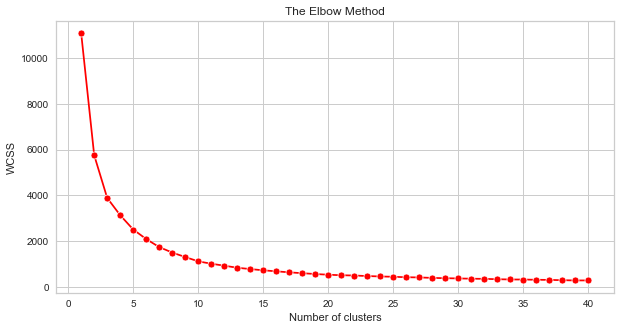

In [72]:

from sklearn.cluster import KMeans

num_clust = 40

wcss = []

for i in range(1, num_clust+1):
    print(f'processing for k={i}')
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(nutrition_df)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))

sns.lineplot(range(1, num_clust+1), wcss,marker='o',color='red')

plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


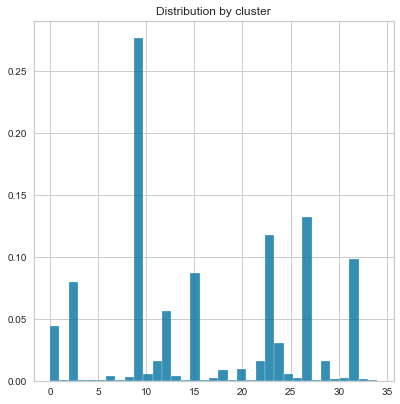

In [73]:
num_clust = 35

kmeans = KMeans(n_clusters = num_clust, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(nutrition_df)

nutrition_df.loc[:, 'cluster'] = y_kmeans

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    y_kmeans,
    bins=num_clust,
    density=True,
    alpha=0.8
)

plt.title('Distribution by cluster')
plt.show()

In [74]:
contant_df['cluster']=nutrition_df['cluster']

### Let's use this information for recommendtion


In [75]:
contant_df[contant_df["name"]=='the most ultimate buttery cream cheese pound cake']

,index,recipe_id,Positive,Negetive,Neutral,rating,name,id,minutes,contributor_id,...,n_ingredients,NewTag,nutrition_f2,nutrition_f1,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7,cluster
1581,1581,78552,58.0,5.0,2.0,4.369231,the most ultimate buttery cream cheese pound cake,78552,70,89831,...,7,"['butter','creamcheese','sugar','eggs','vanill...",0.022108,0.004935,0.442434,-0.165777,-0.175514,0.19583,0.196509,12


In [76]:
cluster_val=contant_df[contant_df["name"]=='the most ultimate buttery cream cheese pound cake']['cluster']
cluster_val=list(cluster_val)[0]

### wacky cake belong to cluster 10

In [77]:
cluster_df=contant_df[(contant_df['cluster']==cluster_val)]

In [78]:
cluster_df.reset_index(inplace = True)

In [79]:
features_df=cluster_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]

In [80]:

from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(features_df)


In [81]:
def RecommendFood2(food,cluster_df,similarity):
    index  = cluster_df[cluster_df['name'] == food].index [0]
    #print(index)
    distance = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    result=[]
    
    for i in distance[1:11]:
      
        result.append(list(cluster_df.iloc[i[0]])[2])
    return result    

In [82]:
cluster_df[cluster_df['name'] == 'the most ultimate buttery cream cheese pound cake']

,level_0,index,recipe_id,Positive,Negetive,Neutral,rating,name,id,minutes,...,n_ingredients,NewTag,nutrition_f2,nutrition_f1,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7,cluster
86,1581,1581,78552,58.0,5.0,2.0,4.369231,the most ultimate buttery cream cheese pound cake,78552,70,...,7,"['butter','creamcheese','sugar','eggs','vanill...",0.022108,0.004935,0.442434,-0.165777,-0.175514,0.19583,0.196509,12


In [83]:
resuls=RecommendFood2('the most ultimate buttery cream cheese pound cake',cluster_df,similarity)

In [84]:
resuls

[8972, 9186, 241166, 91644, 67781, 28026, 87864, 50331, 114575, 67256]

In [85]:
result_df=contant_df[contant_df["recipe_id"].isin(resuls)].sort_values(by=['Positive','rating'], ascending=[False,False])

In [86]:
result_df

,index,recipe_id,Positive,Negetive,Neutral,rating,name,id,minutes,contributor_id,...,n_ingredients,NewTag,nutrition_f2,nutrition_f1,nutrition_f3,nutrition_f4,nutrition_f5,nutrition_f6,nutrition_f7,cluster
35,35,67256,1257.0,38.0,27.0,4.329047,best ever banana cake with cream cheese frosting,67256,75,82367,...,13,"['bananas','lemonjuice','flour','bakingsoda','...",-0.028833,0.045520,0.817934,-0.236944,-0.175514,0.123724,0.510544,12
819,819,8972,173.0,15.0,4.0,3.880208,waldorf astoria red velvet cake,8972,45,2178,...,14,"['shortening','sugar','eggs','redfoodcoloring'...",0.039088,0.052438,0.544356,-0.189499,-0.181350,0.138145,0.331095,12
427,427,67781,149.0,2.0,5.0,4.653846,doctored up vanilla pudding casserole,67781,15,95072,...,7,"['pepperidgefarmchessmencookies','bananas','mi...",0.030598,0.083799,0.705284,-0.236944,-0.146332,0.275147,0.510544,12
334,334,87864,138.0,7.0,4.0,4.610738,super peanut butter filled brownies,87864,60,117781,...,13,"['chocolate','unsaltedbutter','eggs','sugar','...",0.073049,-0.000692,0.490713,-0.319971,-0.169677,0.210251,0.106785,12
826,826,91644,123.0,3.0,2.0,4.414062,amanda s cheese pound cake,91644,105,55882,...,6,"['butter','creamcheese','sugar','eggs','flour'...",0.123990,0.145783,0.710649,-0.272527,-0.152168,0.368885,0.465682,12
363,363,114575,105.0,2.0,4.0,4.468468,cheesecake factory carrot cake cheesecake,114575,80,112385,...,16,"['creamcheese','granulatedsugar','flour','eggs...",0.166441,0.128811,0.758927,-0.272527,-0.158005,0.130934,0.331095,12
1272,1272,28026,95.0,4.0,4.0,4.621359,saltine candy toffee,28026,20,38978,...,6,"['butter','lightbrownsugar','chocolatechips','...",0.081539,-0.006964,0.453163,-0.272527,-0.210531,0.311200,0.106785,12
657,657,241166,67.0,2.0,0.0,4.913043,yummy oatmeal chocolate chip cookies,241166,45,482376,...,12,"['butter','sugar','brownsugar','eggs','vanilla...",0.005127,0.026888,0.576541,-0.272527,-0.175514,0.166987,0.420820,12
947,947,50331,63.0,2.0,2.0,4.313433,crock pot chocolate mud cake,50331,135,52595,...,13,"['flour','bakingpowder','butter','semisweetcho...",-0.045814,-0.010838,0.603363,-0.248805,-0.175514,0.102092,0.420820,12
1231,1231,9186,59.0,5.0,3.0,4.194030,to die for brownies,9186,50,9690,...,11,"['all-purposeflour','bakingpowder','salt','but...",0.039088,0.043952,0.710649,-0.296249,-0.175514,0.138145,0.331095,12


# Evaluate models

In [87]:
userlist=list(train_df.user_id.unique())[:200]
train_df=train_df[train_df['user_id'].isin(userlist)]
test_df=test_df[test_df['user_id'].isin(userlist)]
result=data.sort_values(by=['user_id','date'],ascending=[True,False])
result=result.groupby('user_id').head(15)



In [88]:
def RecommendFoods(food):
    if(~(contant_df['recipe_id'] == food).any()):
           return list()
    cluster_val=contant_df[contant_df["recipe_id"]==food]['cluster']
    cluster_val=list(cluster_val)[0]
    cluster_df=contant_df[(contant_df['cluster']==cluster_val)]
    cluster_df.reset_index(inplace = True)
    features_df=cluster_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]
    similarity = cosine_similarity(features_df)
    
    index  = cluster_df[cluster_df['recipe_id'] == food].index [0]
    distance = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    result=[]
    
    for i in distance[1:16]:
      
        result.append(list(cluster_df.iloc[i[0]])[2])
    return result    

In [89]:


top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['user_id']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
        
    recipe_id=row['recipe_id'] 
  
   
    indexes = RecommendFoods(recipe_id)
    for ids in indexes:
        if(ids==recipe_id):
            continue
        if(~((result['recipe_id'] == ids) & (result['user_id'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [90]:
# Iterating over values
recommendations=[]
for userid, foods in recommend_dict.items():
    total=0
    mlist=[]
    for i in foods:
        total+=1
        mlist.append(i)
        if(total>15):
            break
    recommendations.append([userid,mlist])
recommendations=pd.DataFrame(recommendations,columns=['user_id','foods'])
usersRecommended=[]
for index, row in recommendations.iterrows():
    if(len(row['foods'])>0):
        usersRecommended.append(row['user_id'])
recommendations=recommendations[recommendations.user_id.isin(usersRecommended)]
test_df=test_df[test_df.user_id.isin(usersRecommended)]

In [91]:
total=0
hit=0
for i in usersRecommended:
    results=recommendations[recommendations.user_id==i]
    results=list(results.foods)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['user_id'] == rs) & (test_df['recipe_id'] ==i) ].any().any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.0
